# Random Forest Survival Analysis. 

Tree based algorithms are also a powerful alternative in survival analysis (SA). As in traditional machine learning, these type of models offer a good balance between robustness and "explicability", which makes them a great option in clinical environments where you need precise predictions in which its drivers can be identified and explained. 

## About the Data

We are going to use Breast Cancer data from a German clinical tria. As described by Scikit-Survival: 
German Breast Cancer Study Group (GBSG-2) on the treatment of node-positive breast cancer patients. It contains data on 686 women and 8 prognostic factors: 1. age, 2. estrogen receptor (estrec), 3. whether or not a hormonal therapy was administered (horTh), 4. menopausal status (menostat), 5. number of positive lymph nodes (pnodes), 6. progesterone receptor (progrec), 7. tumor size (tsize, 8. tumor grade (tgrade).

We are tasked with predicting recurrence-free survival time. In other words, the length of time from the end of primary treatment (such as surgery, radiation, or chemotherapy) until there is evidence of cancer recurrence or until the death of the patient, regardless of the cause

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm


from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest

from time_to_event.utils import dist_histogram, countplot

set_config(display="text")  # displays text representation of estimators

plt.rcParams["figure.figsize"] = (12, 8)
plt.style.use("ggplot")

SEED: int = 123456  # set seed for reproducibility

In [23]:
data_X, y = load_gbsg2()
data_X.head()


,age,estrec,horTh,menostat,pnodes,progrec,tgrade,tsize
0,70.0,66.0,no,Post,3.0,48.0,II,21.0
1,56.0,77.0,yes,Post,7.0,61.0,II,12.0
2,58.0,271.0,yes,Post,9.0,52.0,II,35.0
3,59.0,29.0,yes,Post,4.0,60.0,II,17.0
4,73.0,65.0,no,Post,1.0,26.0,II,35.0


In [24]:
y[:5]

array([( True, 1814.), ( True, 2018.), ( True,  712.), ( True, 1807.),
       ( True,  772.)], dtype=[('cens', '?'), ('time', '<f8')])

##  EDA

In [25]:
eda_df = pd.concat(
   [ 
       data_X,
       pd.Series(y["cens"], name="cens"),
       pd.Series(y["time"], name="time")
    ],
    axis=1
)

In [26]:
eda_df.describe()

,age,estrec,pnodes,progrec,tsize,time
count,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000
mean,53.052478,96.252187,5.010204,109.995627,29.329446,1124.489796
std,10.120739,153.083963,5.475483,202.331552,14.296217,642.791948
min,21.000000,0.000000,1.000000,0.000000,3.000000,8.000000
25%,46.000000,8.000000,1.000000,7.000000,20.000000,567.750000
50%,53.000000,36.000000,3.000000,32.500000,25.000000,1084.000000
75%,61.000000,114.000000,7.000000,131.750000,35.000000,1684.750000
max,80.000000,1144.000000,51.000000,2380.000000,120.000000,2659.000000


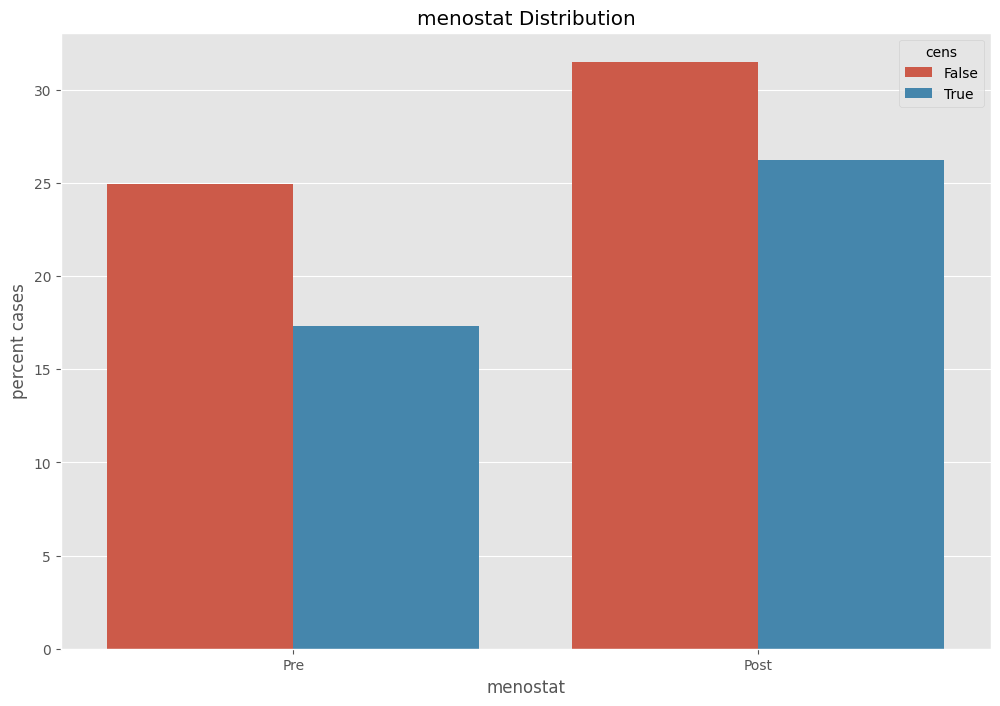

In [27]:
countplot(
    df=eda_df,
    x='menostat', 
    hue="cens",
    stat="percent"
)

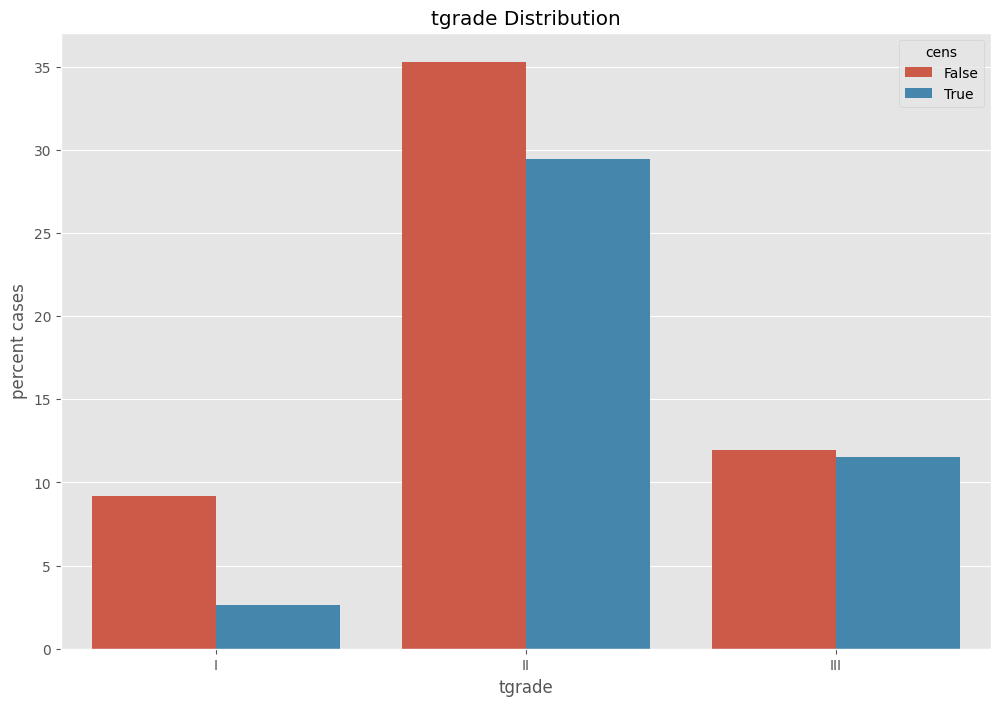

In [28]:
countplot(
    df=eda_df,
    x='tgrade', 
    hue="cens",
    stat="percent"
)

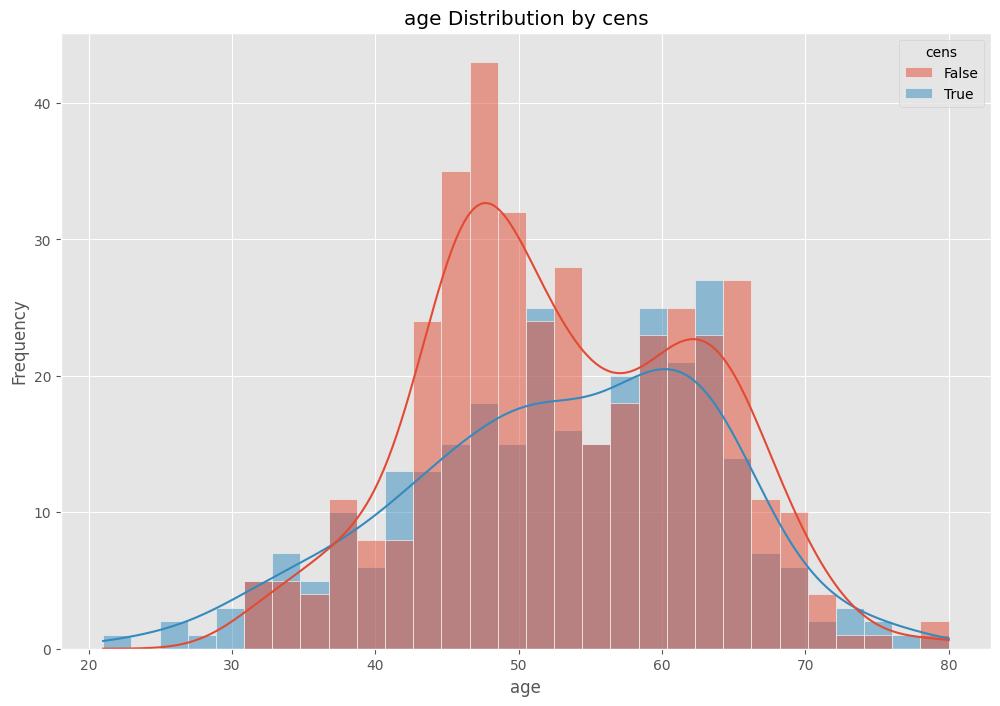

In [29]:
dist_histogram(eda_df, "age", color="b", hue_="cens")

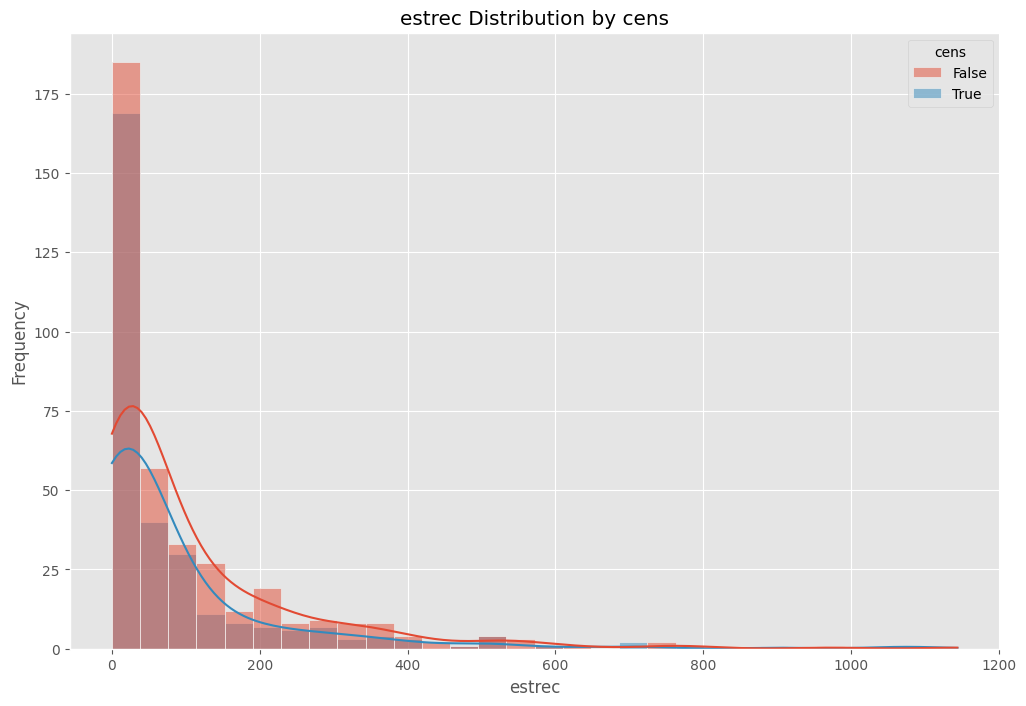

In [30]:
dist_histogram(eda_df, "estrec", color="b", hue_="cens")

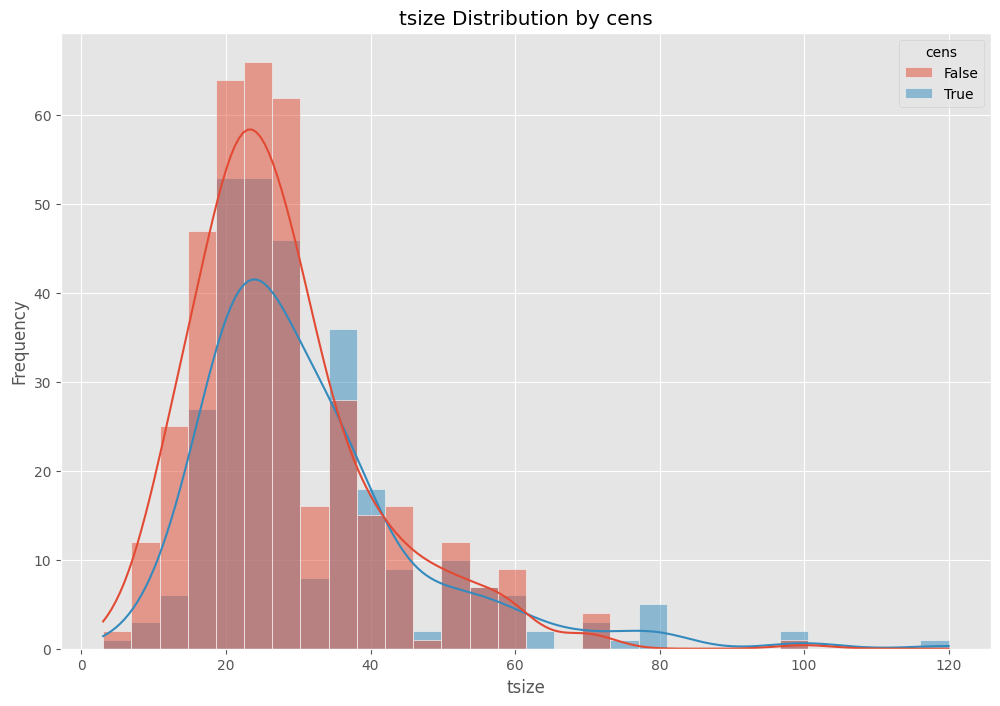

In [31]:
dist_histogram(eda_df, "tsize", color="b", hue_="cens")

## Modelling

In [32]:
# we are going to use one-hot encoding for the non numeric variables.
# however, we want to mantain an order when it's important
ordered_grade = OrdinalEncoder(
    categories=[["I", "II", "III"]]  # lowest to largest
).fit_transform(data_X.tgrade.values.reshape(-1, 1))

x_no_grade = data_X.drop(columns=["tgrade"])
X = OneHotEncoder().fit_transform(x_no_grade)
# re-adding the grade column with proper ordering information.
X["tgrade"] = ordered_grade


In [33]:
TEST_SIZE: float = 0.3

# Split train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=TEST_SIZE,
    random_state=SEED
)

In [34]:
# set up model params. I recommend playing with this to have different outcomes
# You can also (and should) perform Cross Validation as you would with Scikit learn traditional ML
model_params: dict = {
    "n_estimators": 1_000,
    "min_samples_split":8,
    "min_samples_leaf":12,
    "n_jobs":-1, 
    "random_state":SEED
}

rsf = RandomSurvivalForest(**model_params)
# Train the model
rsf.fit(X_train, y_train)

RandomSurvivalForest(min_samples_leaf=12, min_samples_split=8,
                     n_estimators=1000, n_jobs=-1, random_state=123456)

### Model Evaluation. 

We are still using the concordance index, as described in the [Introduction](./introduction.ipynb) Notebook

In [35]:
# Evaluation
# Again 
print("Concordance Index:")
print(round(rsf.score(X_test, y_test), 2))

Concordance Index:
0.69


### Inspecting predictions

For simplicity, let's sort the patients by pnodes and age. Pick a _N_ sample of the top and the same for the bottom of the resulting dataset, and compare their predicted risk score. 

In [36]:
N: int = 5

X_test_sorted = X_test.sort_values(by=["pnodes", "age"])
X_test_sel = pd.concat((X_test_sorted.head(N), X_test_sorted.tail(N)))

X_test_sel

,age,estrec,horTh=yes,menostat=Post,pnodes,progrec,tsize,tgrade
655,33.0,1.0,1.0,0.0,1.0,1.0,28.0,2.0
574,34.0,37.0,0.0,0.0,1.0,0.0,40.0,2.0
351,34.0,11.0,0.0,0.0,1.0,14.0,3.0,2.0
575,38.0,82.0,0.0,0.0,1.0,138.0,24.0,0.0
405,39.0,110.0,0.0,0.0,1.0,38.0,20.0,1.0
589,64.0,22.0,1.0,1.0,23.0,16.0,40.0,1.0
24,65.0,64.0,0.0,1.0,26.0,2.0,70.0,2.0
8,80.0,59.0,0.0,1.0,30.0,0.0,39.0,1.0
169,33.0,8.0,0.0,0.0,33.0,66.0,15.0,2.0
41,45.0,5.0,0.0,0.0,38.0,160.0,38.0,1.0


In [37]:
pd.Series(rsf.predict(X_test_sel))

0    112.358728
1     90.022489
2     77.552476
3     44.070370
4     60.576754
5    164.664471
6    171.067232
7    164.652459
8    135.694092
9    115.123656
dtype: float64

The predicted risk scores indicate that risk for the bottom patients is higher than that of those on the top of the sample overall. But what can be the case for the first patient?

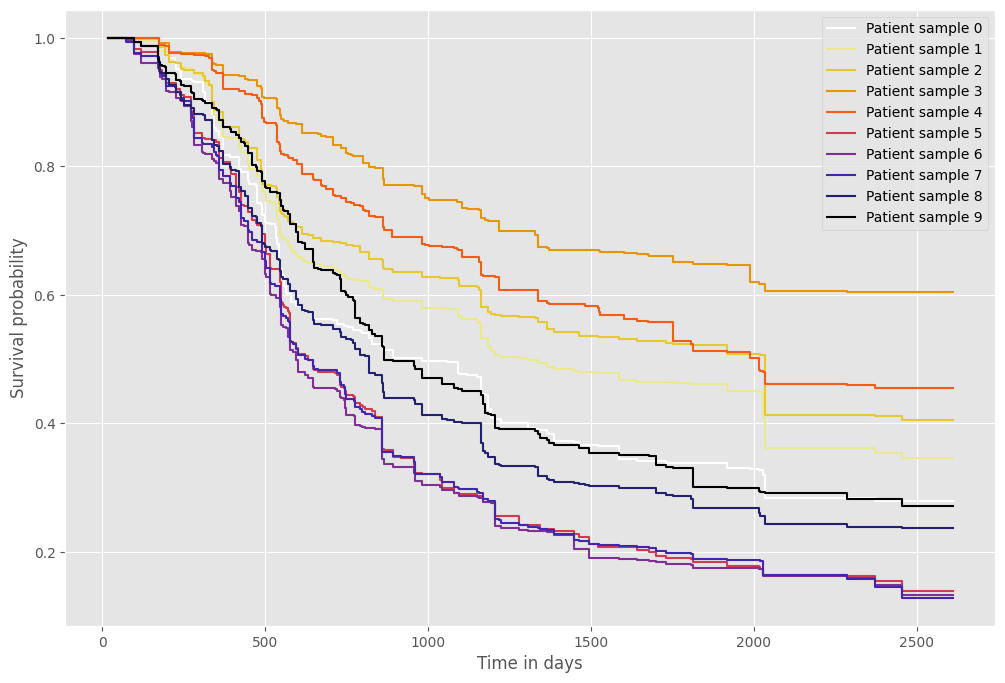

In [38]:
surv = rsf.predict_survival_function(X_test_sel, return_array=True)
# Create a colormap that goes from blue to red
cmap = cm.CMRmap_r
colors = cmap(np.linspace(0, 1, len(surv)))

# Plot each line with a color from the colormap
for i, (s, color) in enumerate(zip(surv, colors)):
    plt.step(rsf.unique_times_, s, where="post", label=f"Patient sample {str(i)}", color=color)
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

Another super useful metric is the **predicted cumulative hazard function**. We can plot it using the Survival package, but firt a brief introduction to what it represents. 


In survival analysis, the predicted cumulative hazard function is a way to describe the risk of an event happening over time.

In simple terms:

Hazard Function: Think of the hazard function as the risk or rate of an event (like failure, death, or relapse) happening at a specific time. It tells you how risky it is for the event to occur at that precise moment, given that the individual has survived up to that time.

Cumulative Hazard Function: Now, the cumulative hazard function adds up these risks over time. It accumulates the risk from the start of the observation period to a specific point in time.


In mathematical terms, if the hazard function at time 
𝑡
t is 
ℎ
(
𝑡
)
h(t), then the cumulative hazard function 
𝐻
(
𝑡
)
H(t) is the integral of 
ℎ
(
𝑡
)
h(t) from the start time to time 
𝑡
t:

𝐻
(
𝑡
)
=
∫
0
𝑡
ℎ
(
𝑢
)
 
𝑑
𝑢
H(t)=∫ 
0
t
​
 h(u)du

In survival analysis, the cumulative hazard function helps in understanding the total risk accumulated over a period and can be used to estimate the survival function, which tells us the probability of surviving up to a certain time

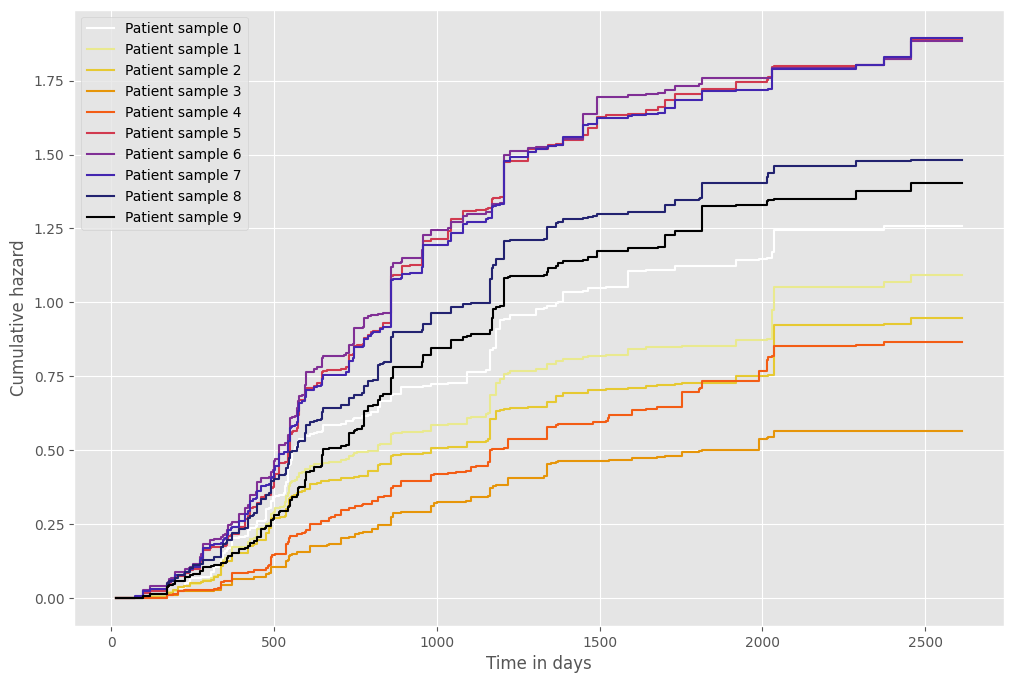

In [39]:
surv = rsf.predict_cumulative_hazard_function(X_test_sel, return_array=True)

cmap = cm.CMRmap_r
colors = cmap(np.linspace(0, 1, len(surv)))

# Plot each line with a color from the colormap
for i, (s, color) in enumerate(zip(surv, colors)):
    plt.step(rsf.unique_times_, s, where="post", label=f"Patient sample {str(i)}", color=color)
plt.ylabel("Cumulative hazard")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

## Feature importance

Similar to the ROC, the feature importance metrics in SA have an equivalent metric called [**Permutation Importance**](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance) that allows us to see which features are the main drivers for our predictions. 

In the Scikit-survival library, this is implemented in the permutation_importance function of scikit-learn.

In [40]:
from sklearn.inspection import permutation_importance

N_REPEATS: int = 10

result = permutation_importance(rsf, X_test, y_test, n_repeats=N_REPEATS, random_state=SEED)

In [41]:
importance_df = pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X_test.columns,
).sort_values(by="importances_mean", ascending=False)

importance_df

,importances_mean,importances_std
pnodes,0.073208,0.013822
progrec,0.025651,0.013142
age,0.017923,0.006719
estrec,0.008599,0.010475
horTh=yes,0.005814,0.001088
tgrade,0.002011,0.002562
menostat=Post,-0.000782,0.000962
tsize,-0.001091,0.003367


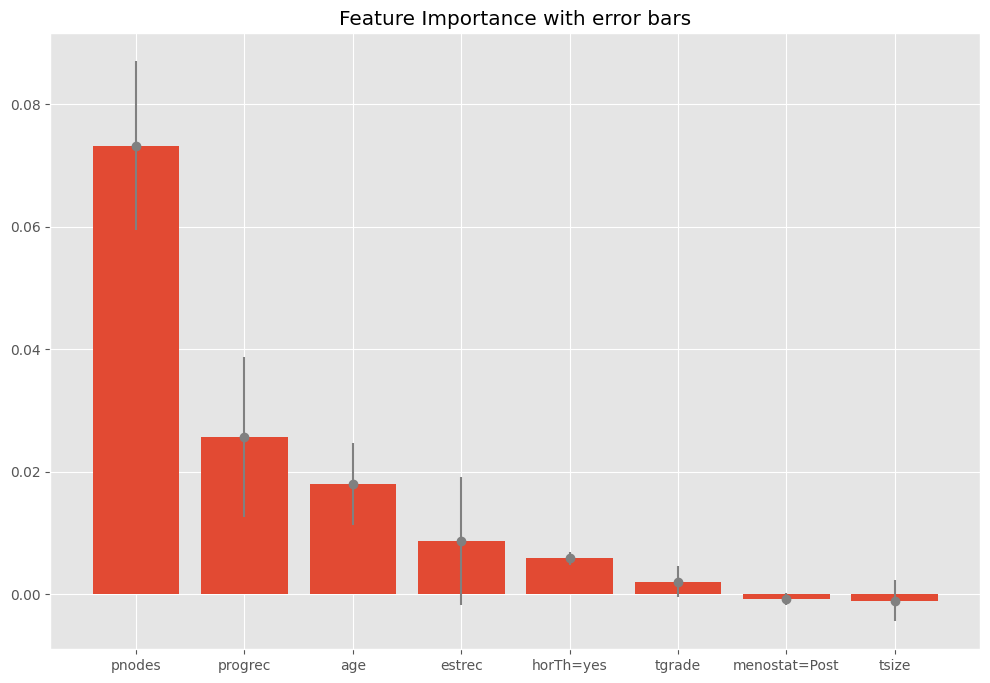

In [42]:

plt.bar(importance_df.index, importance_df.importances_mean)

c = [1, 3, 2, 1]

plt.errorbar(
    importance_df.index,
    importance_df.importances_mean,
    yerr=importance_df.importances_std, 
    fmt="o", 
    color="grey"
)

plt.title("Feature Importance with error bars")
plt.show()
